In [22]:
# IMPORT PACKAGES

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import country_converter as coco
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [5]:
os.chdir("..")
print(os.getcwd())


c:\Users\Marta Gajewska\OneDrive - McKinsey & Company\Documents\PROJECTS\37_nanodegree\Project 1 - SDG\code
c:\Users\Marta Gajewska\OneDrive - McKinsey & Company\Documents\PROJECTS\37_nanodegree\Project 1 - SDG


In [6]:
# READ IN INDICATOR DATA FROM EXCEL FILES

# set path
path = "./data/indicators"

# define function that will be use for each of the files
def read_input_file(file_path):
    """Read in indicator df from specified path.
        Arguments:
        file_path -- string with path to an excel file
    """
    df = pd.read_excel(file_path,
        engine='openpyxl',
        usecols=['Goal', 'Target', 'Indicator', 'GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value'])
    df = df[df['TimePeriod'].between(2008,2012) | df['TimePeriod'].between(2018,2021)]
    return(df)

# create an empty array to store dfs
arr = []  
# iterate through all files
for file in os.listdir(path):
    # check whether file is in xlsx format or not
    if file.endswith(".xlsx"):
        file_path = f"{path}\{file}"
        # call read input file function
        arr.append(read_input_file(file_path))
# concatenate into a single df
df = pd.concat(arr, axis=0, ignore_index=True)
# change type of Value column to numeric
df['Value'] = df['Value'].apply(pd.to_numeric, errors='coerce')

In [7]:
# UNIFY INDICATORS DIRECTION

# merge with helper file
df_indicators = pd.read_excel("./data/additional_data/indicators_direction.xlsx", engine='openpyxl')
df = df.merge(df_indicators, on = "Indicator")
# change indicator direction to "the bigger the better"
df['Value'] = df['Value'] * df['Direction']
df = df.drop('Direction', 1)

In [8]:
# STANDARDIZE VALUES OF INDICATORS

df_standardized = df.copy()
df_standardized['Value'] = df.groupby('Indicator')['Value'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [9]:
# DEFINE STARTING AND ENDING VALUES OF INDICATORS

# change df structure  
df_start_end = pd.pivot_table(df_standardized, index = ["Goal", "Target", "Indicator", "GeoAreaCode", "GeoAreaName"], columns='TimePeriod', values='Value').add_prefix("year_").reset_index()

# use 2010 as a starting point and 2020 as an ending point
df_start_end['starting_value'] = df_start_end['year_2010']
df_start_end['ending_value'] = df_start_end['year_2020']

# fill missing starting & ending point values for every indicator and country with values from +- 1-2 years
df_start_end.starting_value.fillna(df_start_end.year_2009,inplace=True)
df_start_end.starting_value.fillna(df_start_end.year_2011,inplace=True)
df_start_end.starting_value.fillna(df_start_end.year_2012,inplace=True)

df_start_end.ending_value.fillna(df_start_end.year_2019,inplace=True)
df_start_end.ending_value.fillna(df_start_end.year_2018,inplace=True)


In [10]:
# CALCULATE PROGRESS SCORE 

# calculate difference in indicator value over analyzed period
df_start_end['difference'] = df_start_end['ending_value'] - df_start_end['starting_value']
df_start_end = df_start_end[df_start_end.columns.drop(list(df_start_end.filter(regex='year')))]

# calculate overall progress made in analyzed period  
df_progress_score = df_start_end.groupby(["GeoAreaName", "GeoAreaCode"])['difference'].mean().reset_index()
df_progress_score.rename(columns={'difference': 'ProgressScore'}, inplace=True)


In [11]:
# CREATE A DF WITH STARTING VALUES AND PROGRESS FOR EACH AREA

# change format - indicator in columns 
df_start_wide = pd.pivot_table(df_start_end, index = ["GeoAreaCode", "GeoAreaName"], columns='Indicator', values='starting_value').add_prefix("ind_").reset_index()

# join indicators df and progress df 
df_start_progress = df_start_wide.merge(df_progress_score, on = ["GeoAreaCode", "GeoAreaName"])


In [12]:
# DIVIDE PROGRESS SCORES INTO 3 GROUPS

df_start_progress['quantile'] = pd.qcut(df_start_progress['ProgressScore'], 3, labels=['no/slower progress', 'average progress', 'faster progress'])

In [13]:
# LOOKING AT BEST, WORST AND NEGATIVE PROGRESS SCORES

print("# of countries: ", df_start_progress.shape[0])
print("# of countries with negative progress score: ", sum(df_start_progress['ProgressScore']<0))
print("\n Countries with lowest progress scores: \n ", df_start_progress.sort_values('ProgressScore')[['GeoAreaName', 'ProgressScore']].head(10))
print("\n Countries with highest progress scores: \n", df_start_progress.sort_values('ProgressScore')[['GeoAreaName', 'ProgressScore']].tail(10))

# of countries:  254
# of countries with negative progress score:  20

 Countries with lowest progress scores: 
                                          GeoAreaName  ProgressScore
208                                        Zimbabwe      -0.060227
183                                         Réunion      -0.025252
128      China, Macao Special Administrative Region      -0.021744
249              Venezuela (Bolivarian Republic of)      -0.020917
148                                           Nauru      -0.013259
73                                 French Polynesia      -0.011344
96   China, Hong Kong Special Administrative Region      -0.011156
111                                      Kazakhstan      -0.008127
125                                   Liechtenstein      -0.008080
76                                            Gabon      -0.007681

 Countries with highest progress scores: 
                             GeoAreaName  ProgressScore
186                              Rwanda       0.09

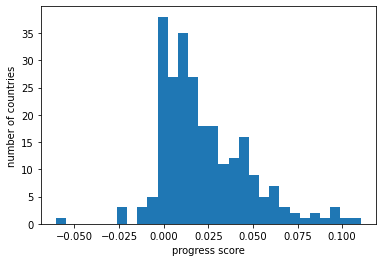

In [14]:
# VISUALIZE PROGRESS SCORE ON A HISTOGRAM
plt.hist(df_start_progress['ProgressScore'], bins=30, alpha=1)
plt.ylabel("number of countries");
plt.xlabel("progress score");


In [43]:
# VISUALIZE PROGRESS SCORE VALUES ON A MAP

# convert country codes to ISO3 codes
df_start_progress['iso3_code'] = coco.convert(names=df_start_progress['GeoAreaCode'], to='ISO3')
# plot a map colored with progress score
fig = px.choropleth(df_start_progress,
                    locations="iso3_code",
                    color="ProgressScore", 
                    hover_name="GeoAreaName",
                    color_continuous_scale=["coral", "coral", "orange", "olive", 'olive'],
                    color_continuous_midpoint=0)                
fig.show()

In [38]:
# VISUALIZE PROGRESS SCORE GROUPS ON A MAP

fig = px.choropleth(df_start_progress,
                    locations="iso3_code",
                    color="quantile", 
                    hover_name="GeoAreaName",
                    color_discrete_sequence = ["olive", "orange", "coral"])

fig.show()


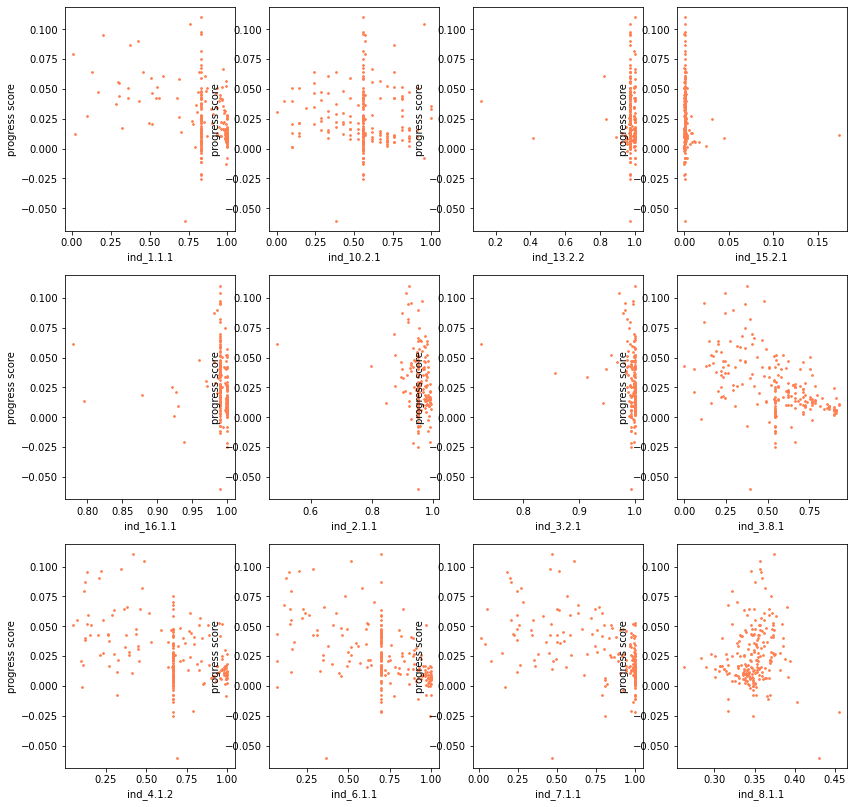

In [41]:
# VISUALIZE RELATION BETWEEN STARTING INDICATOR VALUES AND PROGRESS SCORES
i,j=0,0
plots_per_row = 4
fig, axs = plt.subplots(math.ceil(len(ind_columns)/plots_per_row), plots_per_row, figsize=(12, 16))
for col in ind_columns:
    axs[i][j].scatter(df_start_progress[col], df_start_progress['ProgressScore'], s=3)
    axs[i][j].set_xlabel(col)
    axs[i][j].set_ylabel('progress score')
    j+=1
    if j%plots_per_row==0:
        i+=1
        j=0
plt.show()

In [ ]:
# HANDLING NAN IN STARTING VALUES - PREPARATION FOR PCA & TSNE

# remove rows where less than 75% of indicator values is available
ind_columns = list(df_start_progress.filter(regex='ind'))
df_start_progress = df_start_progress.loc[df_start_progress.isnull().sum(axis=1) < len(ind_columns)*0.75,:]

# remove indicators where less than 25% of values is available 
inds_to_keep  = df_start_progress.columns[df_start_progress.count() > 0.25*df_start_progress.shape[0]]
df_start_progress = df_start_progress[inds_to_keep]

# fill remaining missing values with mean
ind_columns = list(df_start_progress.filter(regex='ind'))

fill_mean = lambda col: col.fillna(col.mean())
df_start_progress[ind_columns] = df_start_progress[ind_columns].apply(fill_mean, axis=0)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 212 samples in 0.000s...
[t-SNE] Computed neighbors for 212 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 212 / 212
[t-SNE] Mean sigma: 0.304463
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.672913
[t-SNE] KL divergence after 500 iterations: 0.154642


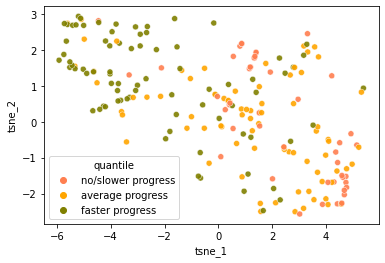

In [46]:
# CALCULATE AND VISUALIZE T-SNE REPRESENTATION
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_start_progress.loc[:, ind_columns].values)

df_start_progress['tsne_1'] = tsne_results[:,0]
df_start_progress['tsne_2'] = tsne_results[:,1]

#plt.figure(figsize=(16,10))
sns.set_palette(sns.color_palette(["coral", "orange", "olive"]))

sns.scatterplot(
    data=df_start_progress, x="tsne_1", y="tsne_2", hue="quantile", legend="full", alpha = 0.9);

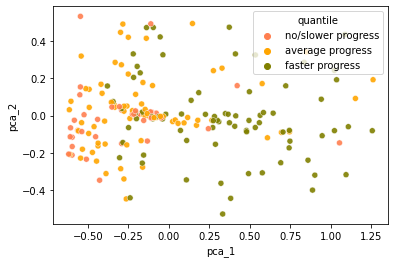

In [37]:
# CALCULATE AND VISUALIZE PCA REPRESENTATION
pca = PCA(n_components=2, svd_solver='full')

x_pca = pca.fit_transform(df_start_progress.loc[:, ind_columns].values)

pca_df = pd.DataFrame(data = x_pca, columns = ['pca_1', 'pca_2'])
pca_df = pd.concat([pca_df.reset_index(), df_start_progress['quantile'].reset_index()], axis = 1)


sns.set_palette(sns.color_palette(["coral", "orange", "olive"]))
sns.scatterplot(data=pca_df, x='pca_1', y='pca_2', hue='quantile', alpha = 0.9, legend="full",);
